In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import Sequential, Input, Model, regularizers
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, Dense, LSTM, Reshape, BatchNormalization, UpSampling1D
from tensorflow.train import AdamOptimizer
import tensorflow as tf

tf.enable_eager_execution()


INPUT_LENGTH = 5000
INPUT_THRESHOLD = 1000

NUM_CLASSES = 3

REGULAR = "reg"
CHIMERIC = "chi"
REPEAT = "rep"
LOW_QUALITY = "loq"


In [12]:
def create_rnn_model():
    model = Sequential()

    # expected input data shape: (batch_size, timesteps, data_dim)
#     model.add(
#         MaxPooling1D(5, input_shape=(INPUT_LENGTH, 1))
#     )
    model.add(
        LSTM(units=32, return_sequences=True, input_shape=(INPUT_LENGTH, 1)) # returns a sequence of vectors of dimension 32
    )
    model.add(
        LSTM(units=32, return_sequences=True)
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(NUM_CLASSES, activation='softmax')
    )

    model.compile(optimizer=AdamOptimizer(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    return model

In [13]:
def create_datasets(tsv_input):
    data = pd.read_csv(tsv_input, delimiter="\t")

    # Filter out all low quality reads
    data = data.loc[data.CAT != LOW_QUALITY]

    # Convert sequence string to float array
    data.PTS = data.PTS.apply(string_to_array)

    # Convert labels from strings to ints
    ys = data.CAT.apply(category_to_int).to_numpy()
    xs = np.stack(data.PTS.array)

    encoded_ys = to_categorical(ys, num_classes=NUM_CLASSES)

    print("XS shape: {}".format(xs.shape))
    print("One-hot encoded YS shape: {}".format(encoded_ys.shape))

    train_x, test_x, train_y, test_y = train_test_split(xs, encoded_ys, test_size=0.3)

    return train_x, train_y, test_x, test_y


def string_to_array(data):
    data_string = str(data)
    split = data_string.split(',')

    return np.array([float(i) for i in split])


def category_to_int(data):
    category = str(data)
    if category == REGULAR:
        return 0
    elif category == REPEAT:
        return 1
    else:
        return 2


def evaluate(model, train_x, train_y, test_x, test_y, epochs_num):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=epochs_num,
        validation_data=(test_x, test_y)
    )
    plot_loss(history, epochs_num)

    pred_y = model.predict(test_x)
    matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
    print(matrix)

    
    print("classification report:")
    print(metrics.classification_report(test_y.argmax(axis=1), pred_y.argmax(axis=1)))
    plot_confusion_matrix(matrix)
    

def plot_loss(model, epochs_num):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(1, epochs_num + 1)
    plt.figure()
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix, ["regular", "repeat", "chimeric"], ["regular", "repeat", "chimeric"])
    plt.figure(figsize=(10, 7))
    sb.heatmap(df_cm, annot=True)
    plt.show()


def test_lstm(dataset):
    model = create_rnn_model()

    train_x, train_y, test_x, test_y = create_datasets(dataset)

    print(np.max(train_x))
    train_x = train_x / np.max(train_x)
    test_x = test_x / np.max(test_x)
    print(np.max(train_x))

    train_x = np.expand_dims(train_x, axis=2)
    #train_y = np.expand_dims(train_y, axis=2)
    test_x = np.expand_dims(test_x, axis=2)
    #test_y = np.expand_dims(test_y, axis=2)
    print(train_x.shape)
    print(train_y.shape)

    evaluate(model, train_x, train_y, test_x, test_y, epochs_num=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5000, 32)          4352      
_________________________________________________________________
lstm_5 (LSTM)                (None, 5000, 32)          8320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 480003    
Total params: 492,675
Trainable params: 492,675
Non-trainable params: 0
_________________________________________________________________
None
XS shape: (330, 5000)
One-hot encoded YS shape: (330, 3)
175.0
1.0
(231, 5000, 1)
(231, 3)
Epoch 1/20
4/4 [==============================] - 692s 173s/step - loss: 0.9866 - acc: 0.5743 - val_loss: 0.8576 - val_acc: 0.7576
Epoch 2/20
4/4 [=========================

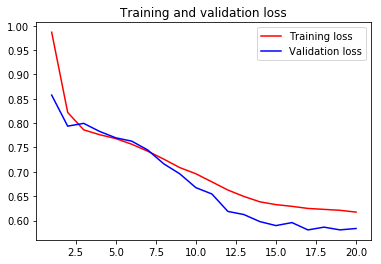

[[ 9 10  0]
 [ 6 69  0]
 [ 1  4  0]]
classification report:
             precision    recall  f1-score   support

          0       0.56      0.47      0.51        19
          1       0.83      0.92      0.87        75
          2       0.00      0.00      0.00         5

avg / total       0.74      0.79      0.76        99



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


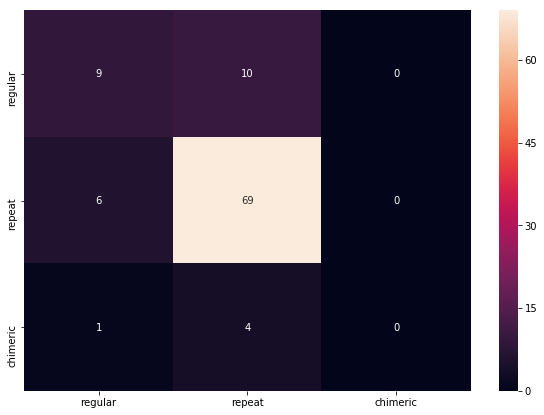

In [14]:
test_lstm("/floyd/input/overlaps/categorized_400.tsv")